# RANSAC example

In this example, we compare the performance of a normal algebraic one step (AOS) Pivot Calibration [Yaniv2010], with a RANSAC version of the same algorithm.


In [59]:
%matplotlib inline

In [60]:
# Jupyter notebook sets the cwd to the folder containing the notebook.
# So, you want to add the root of the project to the sys path, so modules load correctly.
import sys
sys.path.append("../../")

In [61]:
# All imports.
from glob import glob
import copy
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Note that the scikit-surgery libraries provide pivot and RANSAC. 
import sksurgerycore.algorithms.pivot as p   # AOS Pivot algorithm and a RANSAC version.
import sksurgerycore.transforms.matrix as m  # For creating 4x4 matrices.

In [62]:
# Load test data
file_names = glob('PivotCalibrationData/*')
arrays = [np.loadtxt(f) for f in file_names]
matrices = np.concatenate(arrays)
number_of_matrices = int(matrices.size/16)
tracking_matrices = matrices.reshape(number_of_matrices, 4, 4)
print(tracking_matrices.shape)

(1151, 4, 4)


In [63]:
# Do a normal pivot calibration using all data.
model_1, residual_1 = p.pivot_calibration(tracking_matrices)
print("Offset is:" + str(model_1[0:3].T))
print("Pivot is:" + str(model_1[3:6].T))
print("RMS error about centroid is:" + str(residual_1))

Offset is:[[-14.47617201 395.14282161  -7.55790421]]
Pivot is:[[ -805.28473588   -85.44779266 -2112.0664371 ]]
RMS error about centroid is:1.8384664420100074


notice that in the model_1 variable: 

* The first 3 numbers are the coordinates of the tip relative to the tracking marker, the offset.
* The second 3 numbers are the location of the tip in tracking/world coordinate system, the pivot.

So, if we add noisy data, we should be able to see the difference between a normal pivot calibration (least squares), and the RANSAC version. We have about 1000 matrices, so lets add noise up to 100 of them.

In [64]:
# Parameters to play with
number_of_matrices_to_add_noise_to = 100
rotation_offset_in_degrees = 5
translation_offset_in_millimetres = 5
number_iterations = 10
error_in_millimetres = 4
minimum_percentage = 0.25

In [65]:
# Create an array representing how many to add noise to.
rms_error_ls = []
rms_error_RANSAC = []
x_values = []
indices = range(tracking_matrices.shape[0])
for counter in range(0, number_of_matrices_to_add_noise_to, 10):
    matrices_copy = copy.deepcopy(tracking_matrices)
    random_indices = random.sample(indices, counter)
    for random_index in random_indices:
        random_rotation = m.construct_rotm_from_euler((np.random.rand() * rotation_offset_in_degrees*2)-rotation_offset_in_degrees,
                                                      (np.random.rand() * rotation_offset_in_degrees*2)-rotation_offset_in_degrees,
                                                      (np.random.rand() * rotation_offset_in_degrees*2)-rotation_offset_in_degrees,
                                                      "zyx", is_in_radians=False)
        random_translation = np.zeros((3,1))
        random_translation[0][0] = (np.random.rand() * translation_offset_in_millimetres*2)-translation_offset_in_millimetres
        random_translation[1][0] = (np.random.rand() * translation_offset_in_millimetres*2)-translation_offset_in_millimetres
        random_translation[2][0] = (np.random.rand() * translation_offset_in_millimetres*2)-translation_offset_in_millimetres
        random_transform = m.construct_rigid_transformation(random_rotation, random_translation)
        matrices_copy[random_index] = matrices_copy[random_index] @ random_transform
    model_2, residual_2 = p.pivot_calibration(matrices_copy)
    model_3, residual_3 = p.pivot_calibration_with_ransac(matrices_copy, number_iterations, error_in_millimetres, minimum_percentage)
    x_values.append(counter)
    rms_error_ls.append(residual_2)
    rms_error_RANSAC.append(residual_3)

RANSAC Pivot, from 1151 matrices, used 1022 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 987 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 970 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 970 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 967 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 895 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 929 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 951 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from 1151 matrices, used 937 matrices, with error threshold = 4 and consensus threshold = 0.25
RANSAC Pivot, from

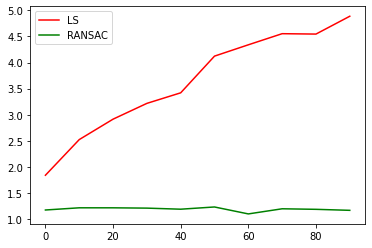

In [56]:
plt.plot(x_values, rms_error_ls, 'r', label='LS')  
plt.plot(x_values, rms_error_RANSAC, 'g', label='RANSAC') 
plt.legend(loc='upper left')
plt.show()